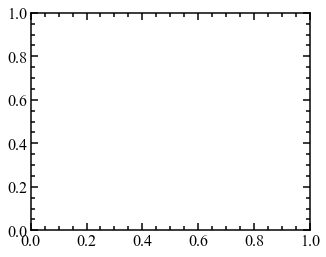

In [1]:
import sys
sys.dont_write_bytecode = True
import time
import numpy as np
from matplotlib import pyplot as plt
sys.path.append('/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/')
from Fluxonium_hamiltonians import qchard_fluxonium as fluxonium
from Fluxonium_hamiltonians import qchard_resonator as resonator
from Fluxonium_hamiltonians import qchard_coupobj as coupobj
import plotting_settings
import matplotlib as mpl
mpl.rcParams['figure.dpi']= 400
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Times New Roman']
figpath = '/Users/longnguyen/Google Drive/LBL Research/Illustration/HCF paper/'

# Parameters

In [126]:
nlev_lc = 30
nlev_single = 7  # The number of single-qubit levels to show.
take_data_from_input_file = False

if not take_data_from_input_file:
    # Parameters of the first fluxonium.
    E_L1 = 0.61 # inductive energy
    E_C1 = 1.0  # charging energy
    E_J1 = 3.5  # Josephson energy
    phi_ext1 = np.pi  # external phase shift

    # Parameters of the second fluxonium.
    E_L2 = 0.74  # inductive energy
#     E_L2 = 1.6  # inductive energy
    E_C2 = 1.0  # charging energy
    E_J2 = 3.5  # Josephson energy
    phi_ext2 = np.pi  # external phase shift

    # Interaction energy between two fluxoniums.
    # E_int n_1 n_2 or E_int phi_1 phi_2.
    E_int = 0.2  # when a single value is needed
    E_int_range = np.linspace(0, 0.3, 11)  # when a range is needed
    coupling = 'charge'  # 'charge' or 'flux'
    
    # Parameters of the coupling resonators
    omega_c = 6 

qubit1 = fluxonium.Fluxonium(E_J = E_J1, E_C=E_C1, E_L=E_L1, phi_ext=phi_ext1, nlev = nlev_single, nlev_lc = nlev_lc)
qubit2 = fluxonium.Fluxonium(E_J = E_J2, E_C=E_C2, E_L=E_L2, phi_ext=phi_ext2, nlev = nlev_single, nlev_lc = nlev_lc)
coupl_res = resonator.Cavity(omega=omega_c, nlev=5)

print("Qubit A: %s" % (qubit1))
print("Qubit B: %s" % (qubit2))
print("Resonator: %s" % (resonator))

anchor_freq1 = qubit1.freq(0,1)
anchor_freq2 = qubit2.freq(0,1)
freq_anchor = anchor_freq2 - anchor_freq1
print (anchor_freq1)
print (anchor_freq2)
print (freq_anchor)

Qubit A: A fluxonium qubit with E_L = 0.61 GHz, E_C = 1.0 GHz, and E_J = 3.5 GHz. The external phase shift is phi_ext/pi = 1.0.
Qubit B: A fluxonium qubit with E_L = 0.74 GHz, E_C = 1.0 GHz, and E_J = 3.5 GHz. The external phase shift is phi_ext/pi = 1.0.
Resonator: <module 'Fluxonium_hamiltonians.qchard_resonator' from '/Users/longnguyen/Documents/GitHub/Fluxonium_berkeley/Fluxonium_hamiltonians/qchard_resonator.py'>
0.3995116435689543
0.5069597880943648
0.10744814452541052


# Sweep coupling to resonator

In [141]:
#Sweep the coupling strength, JC-charge
g_array = np.linspace(0, 0.3, 31)
J_C_direct = 0.000
phi_ext = np.pi
qubit1.phi_ext = phi_ext
qubit2.phi_ext = phi_ext
# print (qubit1.n_ij(level1=0,level2=1))
# print (qubit2.n_ij(level1=0,level2=1))
# print (qubit1.phi_ij(level1=0,level2=1))
# print (qubit2.phi_ij(level1=0,level2=1))
energies_coupled_swE = np.zeros((qubit1.nlev * qubit2.nlev*coupl_res.nlev, len(g_array)))
m_element_charge = np.zeros_like(g_array)
m_element_flux = np.zeros_like(g_array)
for idx, g in enumerate(g_array):
    system = coupobj.CoupledObjects(qubit1, qubit2, coupl_res,
                                    [qubit1, qubit2, J_C_direct, 'charge'],
                                    [qubit1, coupl_res, g, 'JC-charge'],
                                    [qubit2, coupl_res, g, 'JC-charge'])
    energies_coupled_swE[:,idx] = system.levels()
    m_element_charge[idx] = abs(system.n(0).matrix_element(system.eigvec('000'), system.eigvec('010')))
    m_element_flux[idx] = abs(system.phi(0).matrix_element(system.eigvec('000'), system.eigvec('010')))

(0.0, 0.3)

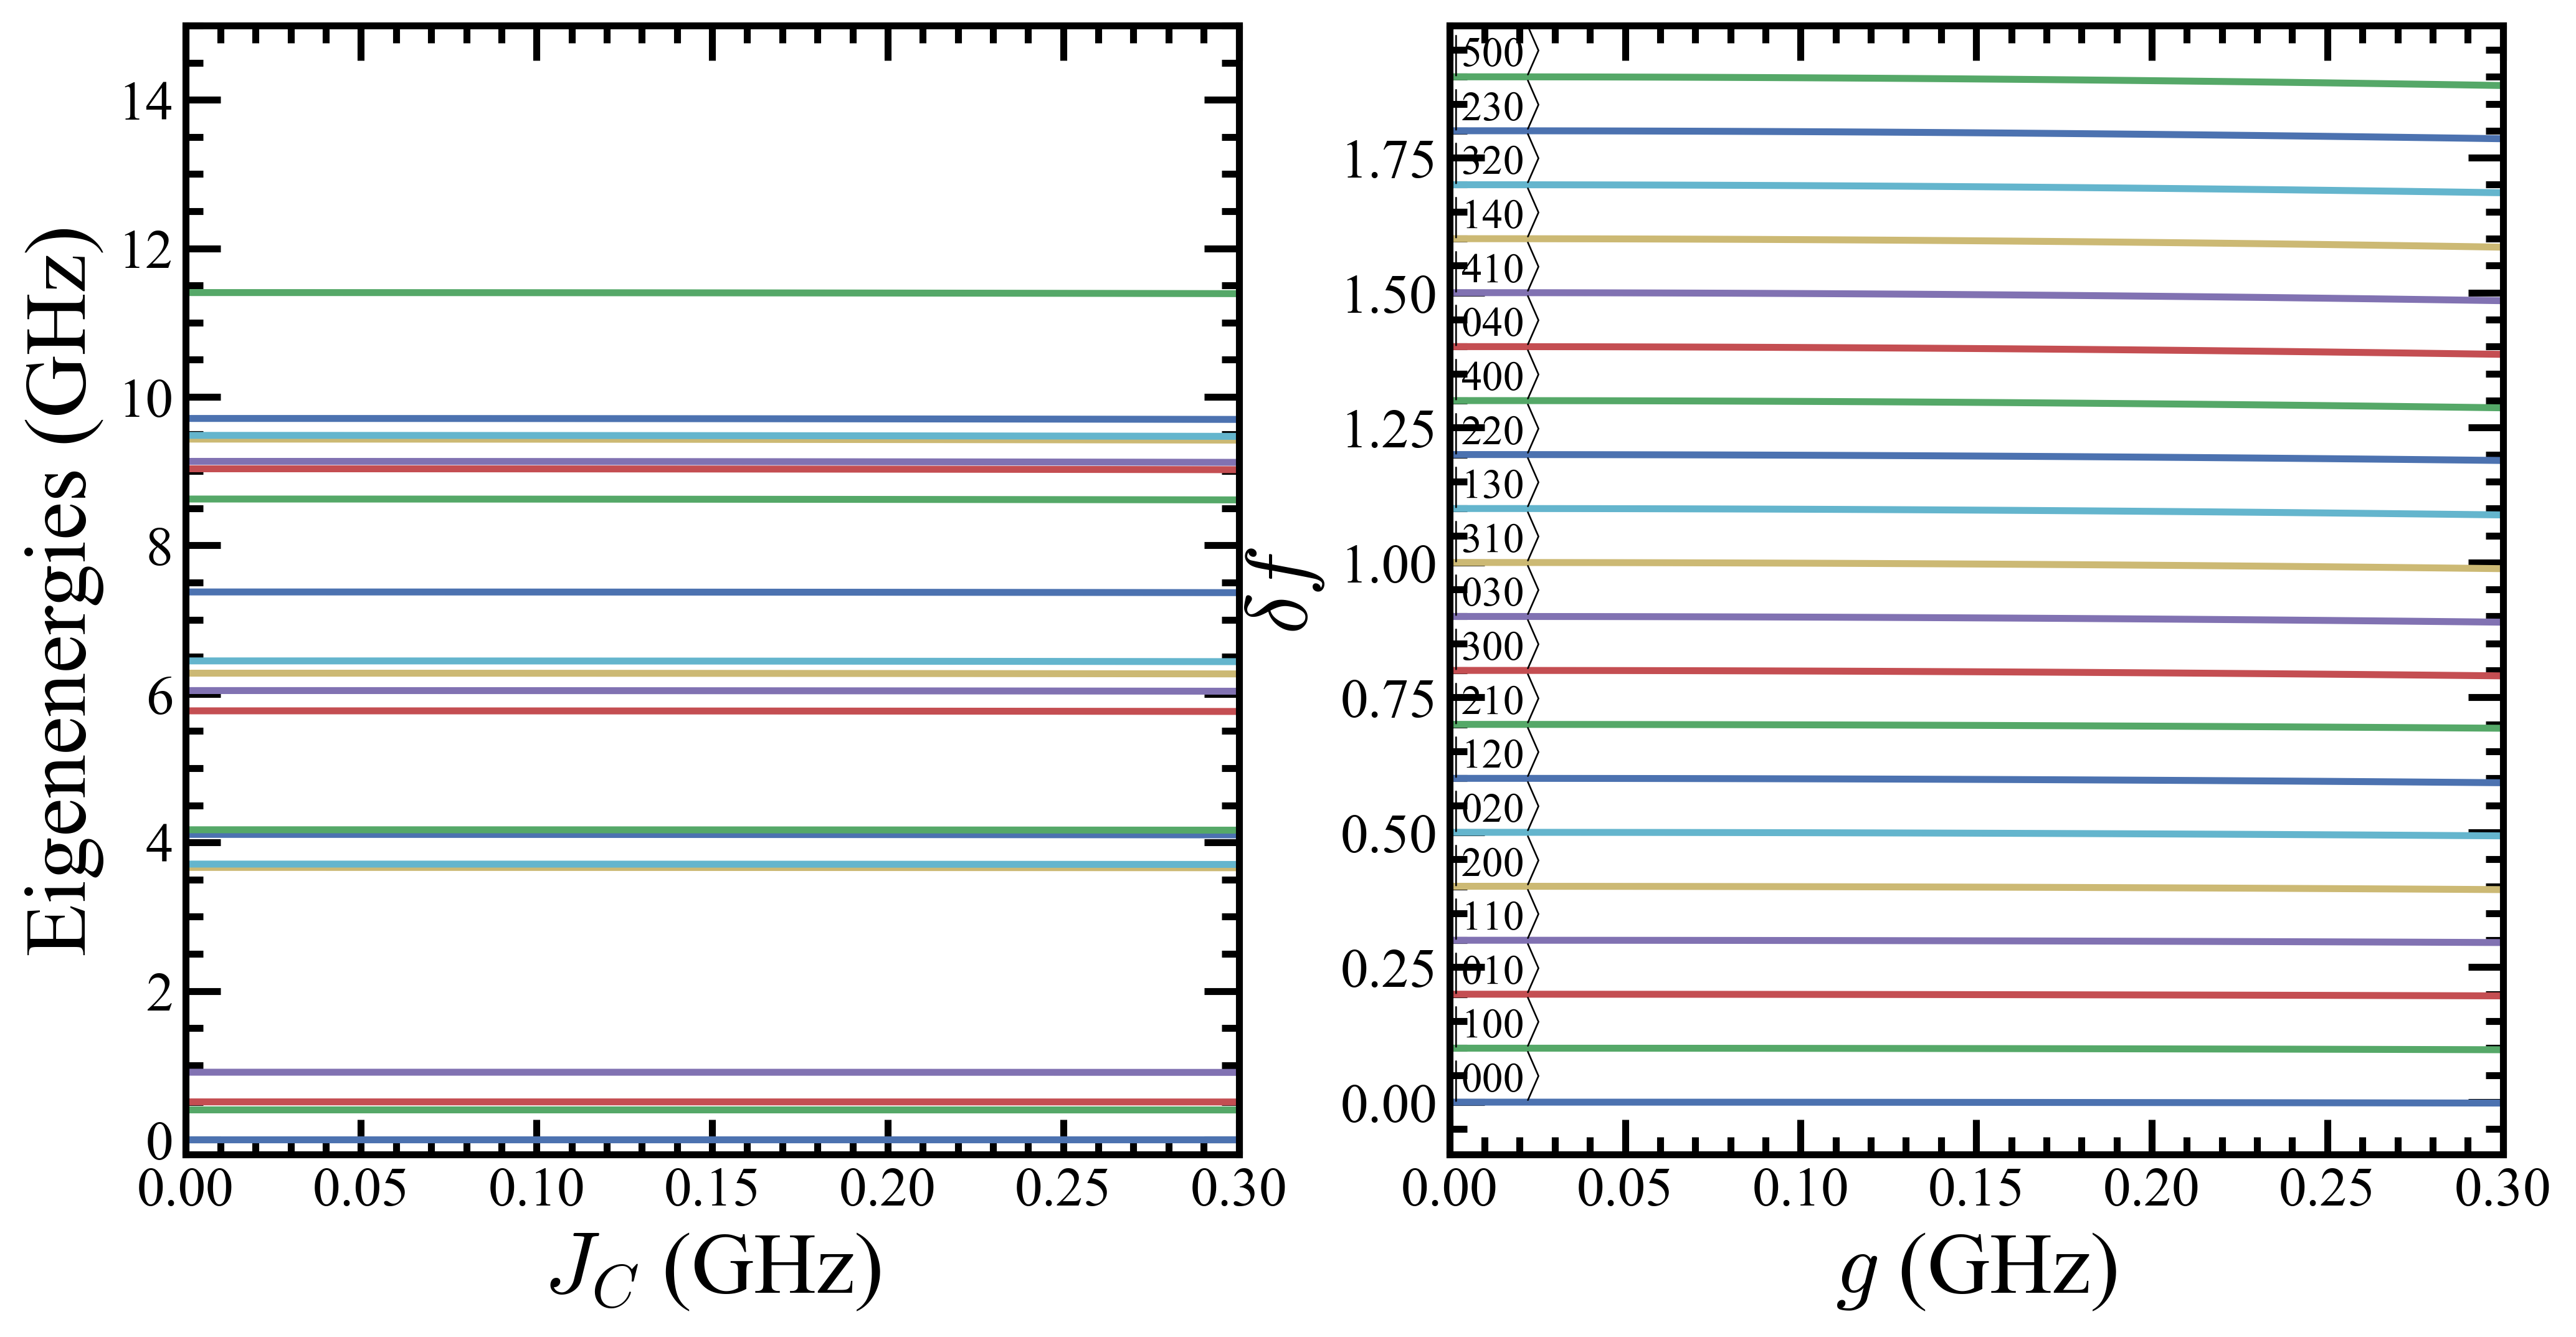

In [138]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = [12,6])
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

nlev_show = 20
#Transition freqs
for idx in range(0, nlev_show):
    ax1.plot(g_array, energies_coupled_swE[idx, :]-energies_coupled_swE[0, :], linewidth = 2.0)
ax1.set_xlabel('$J_C$ (GHz)')
ax1.set_ylabel('Eigenenergies (GHz)')
ax1.set_xlim([g_array[0], g_array[-1]])
ax1.set_ylim([-0.2,15])

#State labeling
for idx in range(0, nlev_show):
    ax2.plot(g_array, 0.1 * idx+(energies_coupled_swE[idx, :]-energies_coupled_swE[idx, 0]), linewidth = 2.0)
    label = (r'$|$' + system.level_label(idx, label_format='str') + r'$\rangle$')
    ax2.text(0, 0.02 + 0.1 * idx, label, fontsize=12)
ax2.set_xlabel('$g$ (GHz)')
ax2.set_ylabel(r'$\delta f$')
ax2.set_xlim([g_array[0], g_array[-1]])

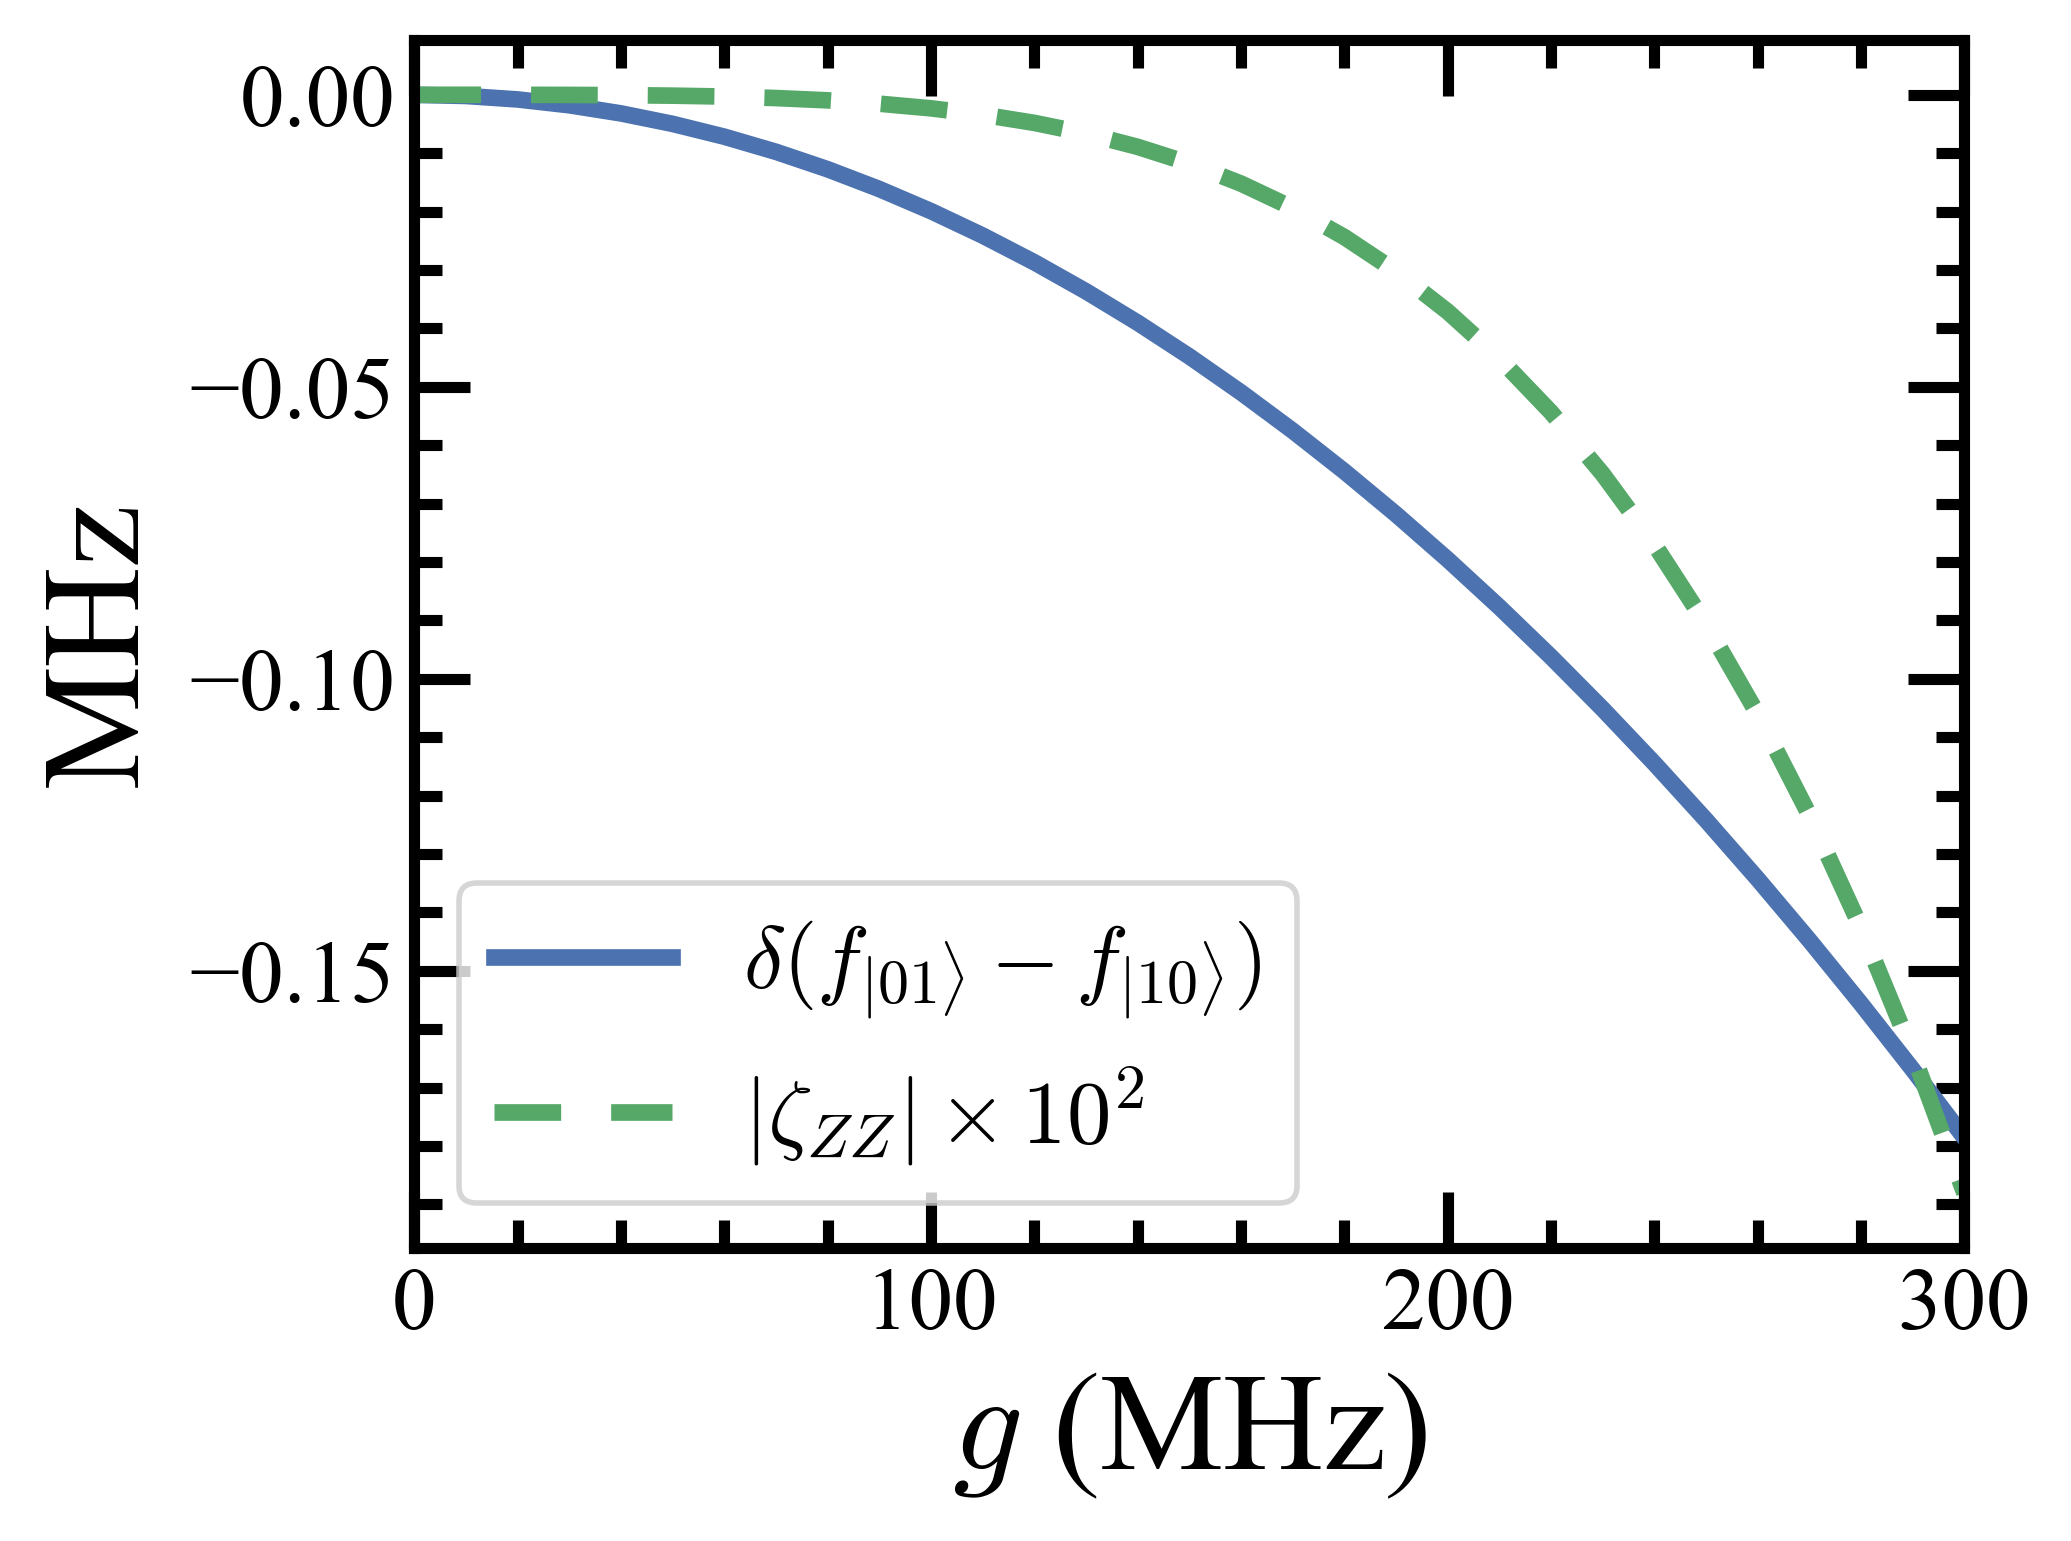

In [139]:
#Calculate ZZ rate:
plt.figure(figsize = [5,4])
zeta_ZZ = energies_coupled_swE[system.level_label('110'),:] - energies_coupled_swE[system.level_label('010'),:] \
- (energies_coupled_swE[system.level_label('100'), :] - energies_coupled_swE[system.level_label('000'), :])
freq_shift = energies_coupled_swE[system.level_label('010'), :] - energies_coupled_swE[system.level_label('100'), :]
freq_shift = freq_shift - freq_anchor
plt.plot(g_array*1e3, (freq_shift)*1e3, label = r'$\delta (f _{|01\rangle} - f _{|10\rangle})$')
plt.plot(g_array*1e3, (zeta_ZZ)*1e5, label = r'$|\zeta_{ZZ}|\times 10^2$',linestyle = '--')

plt.legend()
# plt.tick_params(left=True, right=True,labelleft=True, labelright=True)
# plt.ylabel('MHz')
plt.ylabel(r'MHz')
plt.xlabel('$g$ (MHz)')
plt.xlim([g_array[0]*1e3, g_array[-1]*1e3])
figname = 'virtual_coupling_rate.pdf'
plt.savefig(figpath+figname)

Text(0.5, 0, '$g$ (MHz)')

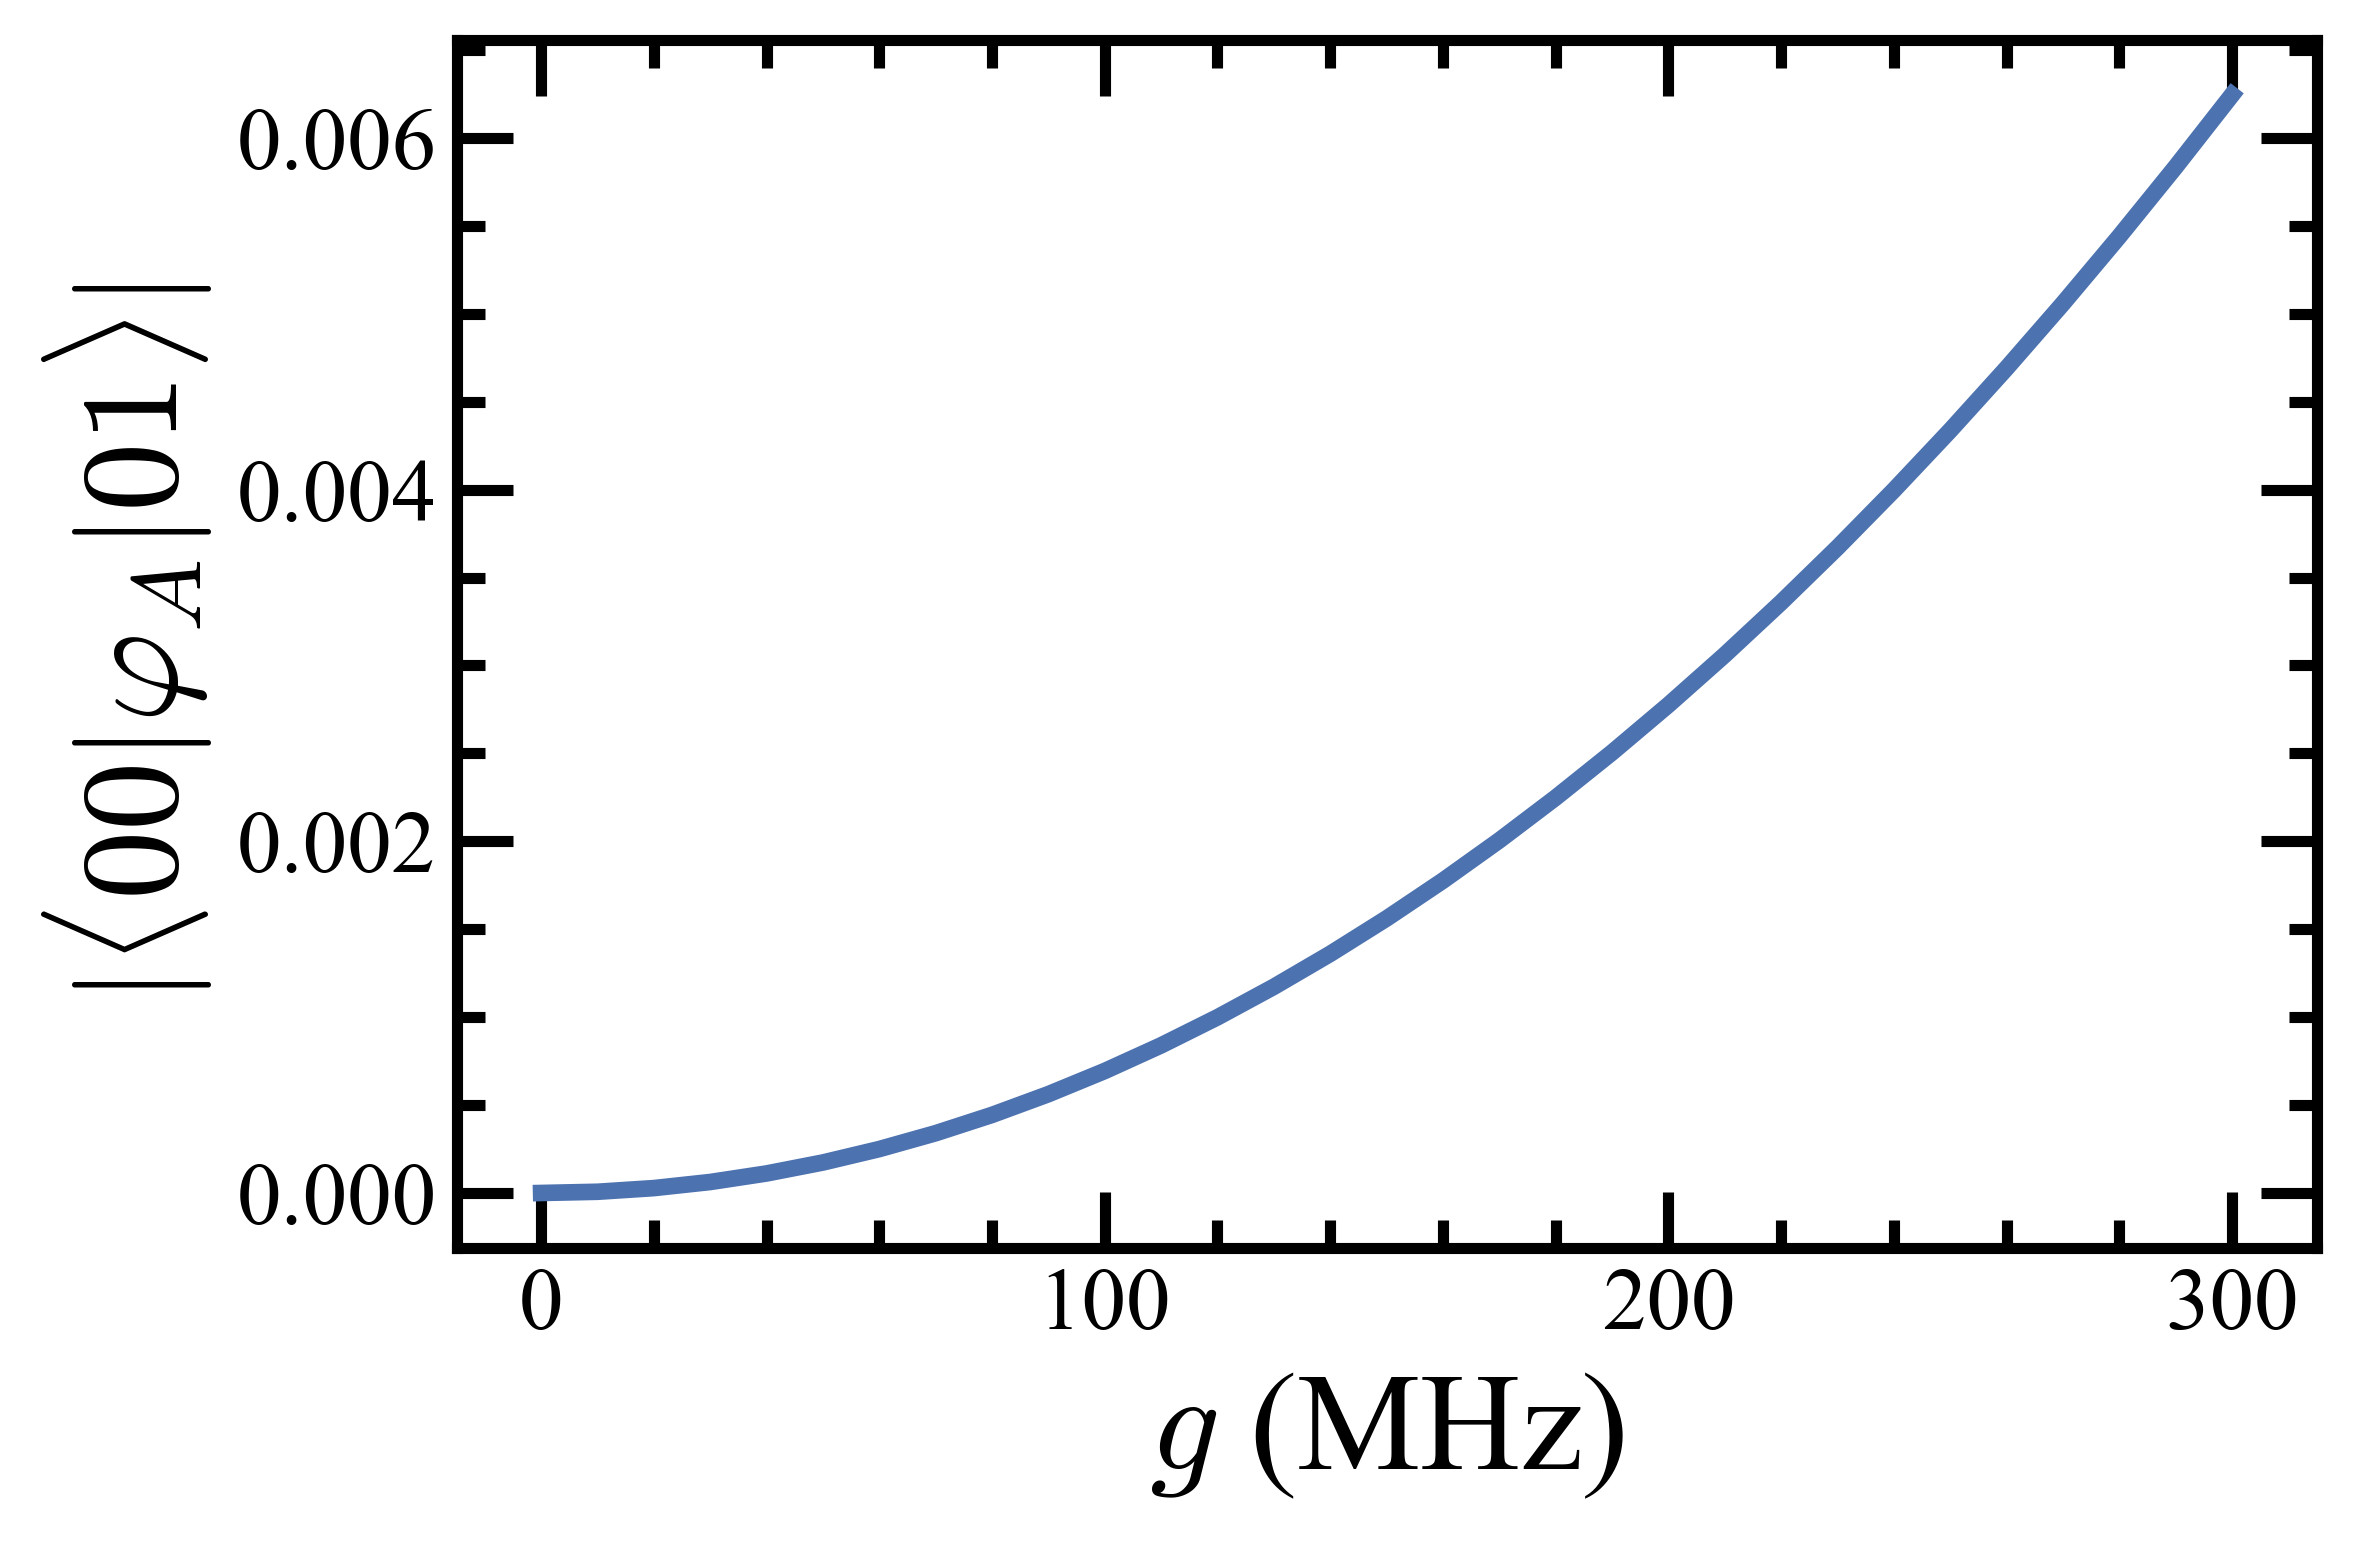

In [142]:
plt.plot(g_array*1e3, m_element_flux)
plt.ylabel(r'$|\langle 00 |\varphi_A |01 \rangle | $')
plt.xlabel('$g$ (MHz)')

# plt.plot(g_array*1e3, m_element_charge)
# plt.ylabel(r'$|\langle 00 |n_A |01 \rangle | $')
# plt.xlabel('$g$ (MHz)')

# Sweep resonator's frequency

In [134]:
## Keep coupling fixed, sweep the resonator's frequency
w_c_array = np.linspace(4,12,41)
m_element_charge = np.zeros_like(w_c_array)
m_element_flux = np.zeros_like(w_c_array)
g = 0.3
J_C = 0.0
phi_ext = np.pi
qubit1.phi_ext = phi_ext
qubit2.phi_ext = phi_ext
energies_coupled_swE = np.zeros((qubit1.nlev * qubit2.nlev*coupl_res.nlev, len(w_c_array)))

for idx, w_c in enumerate(w_c_array):
    coupl_res = resonator.Cavity(omega=w_c, nlev = 5)
    system = coupobj.CoupledObjects(qubit1, qubit2, coupl_res,
                                    [qubit1, qubit2, J_C, 'charge'],
                                    [coupl_res, qubit1, g, 'JC-charge'],
                                    [coupl_res, qubit2, g, 'JC-charge'])
    energies_coupled_swE[:,idx] = system.levels()
    m_element_charge[idx] = abs(system.n(0).matrix_element(system.eigvec('000'), system.eigvec('010')))
    m_element_flux[idx] = abs(system.phi(0).matrix_element(system.eigvec('000'), system.eigvec('010')))

Text(0, 0.5, 'MHz')

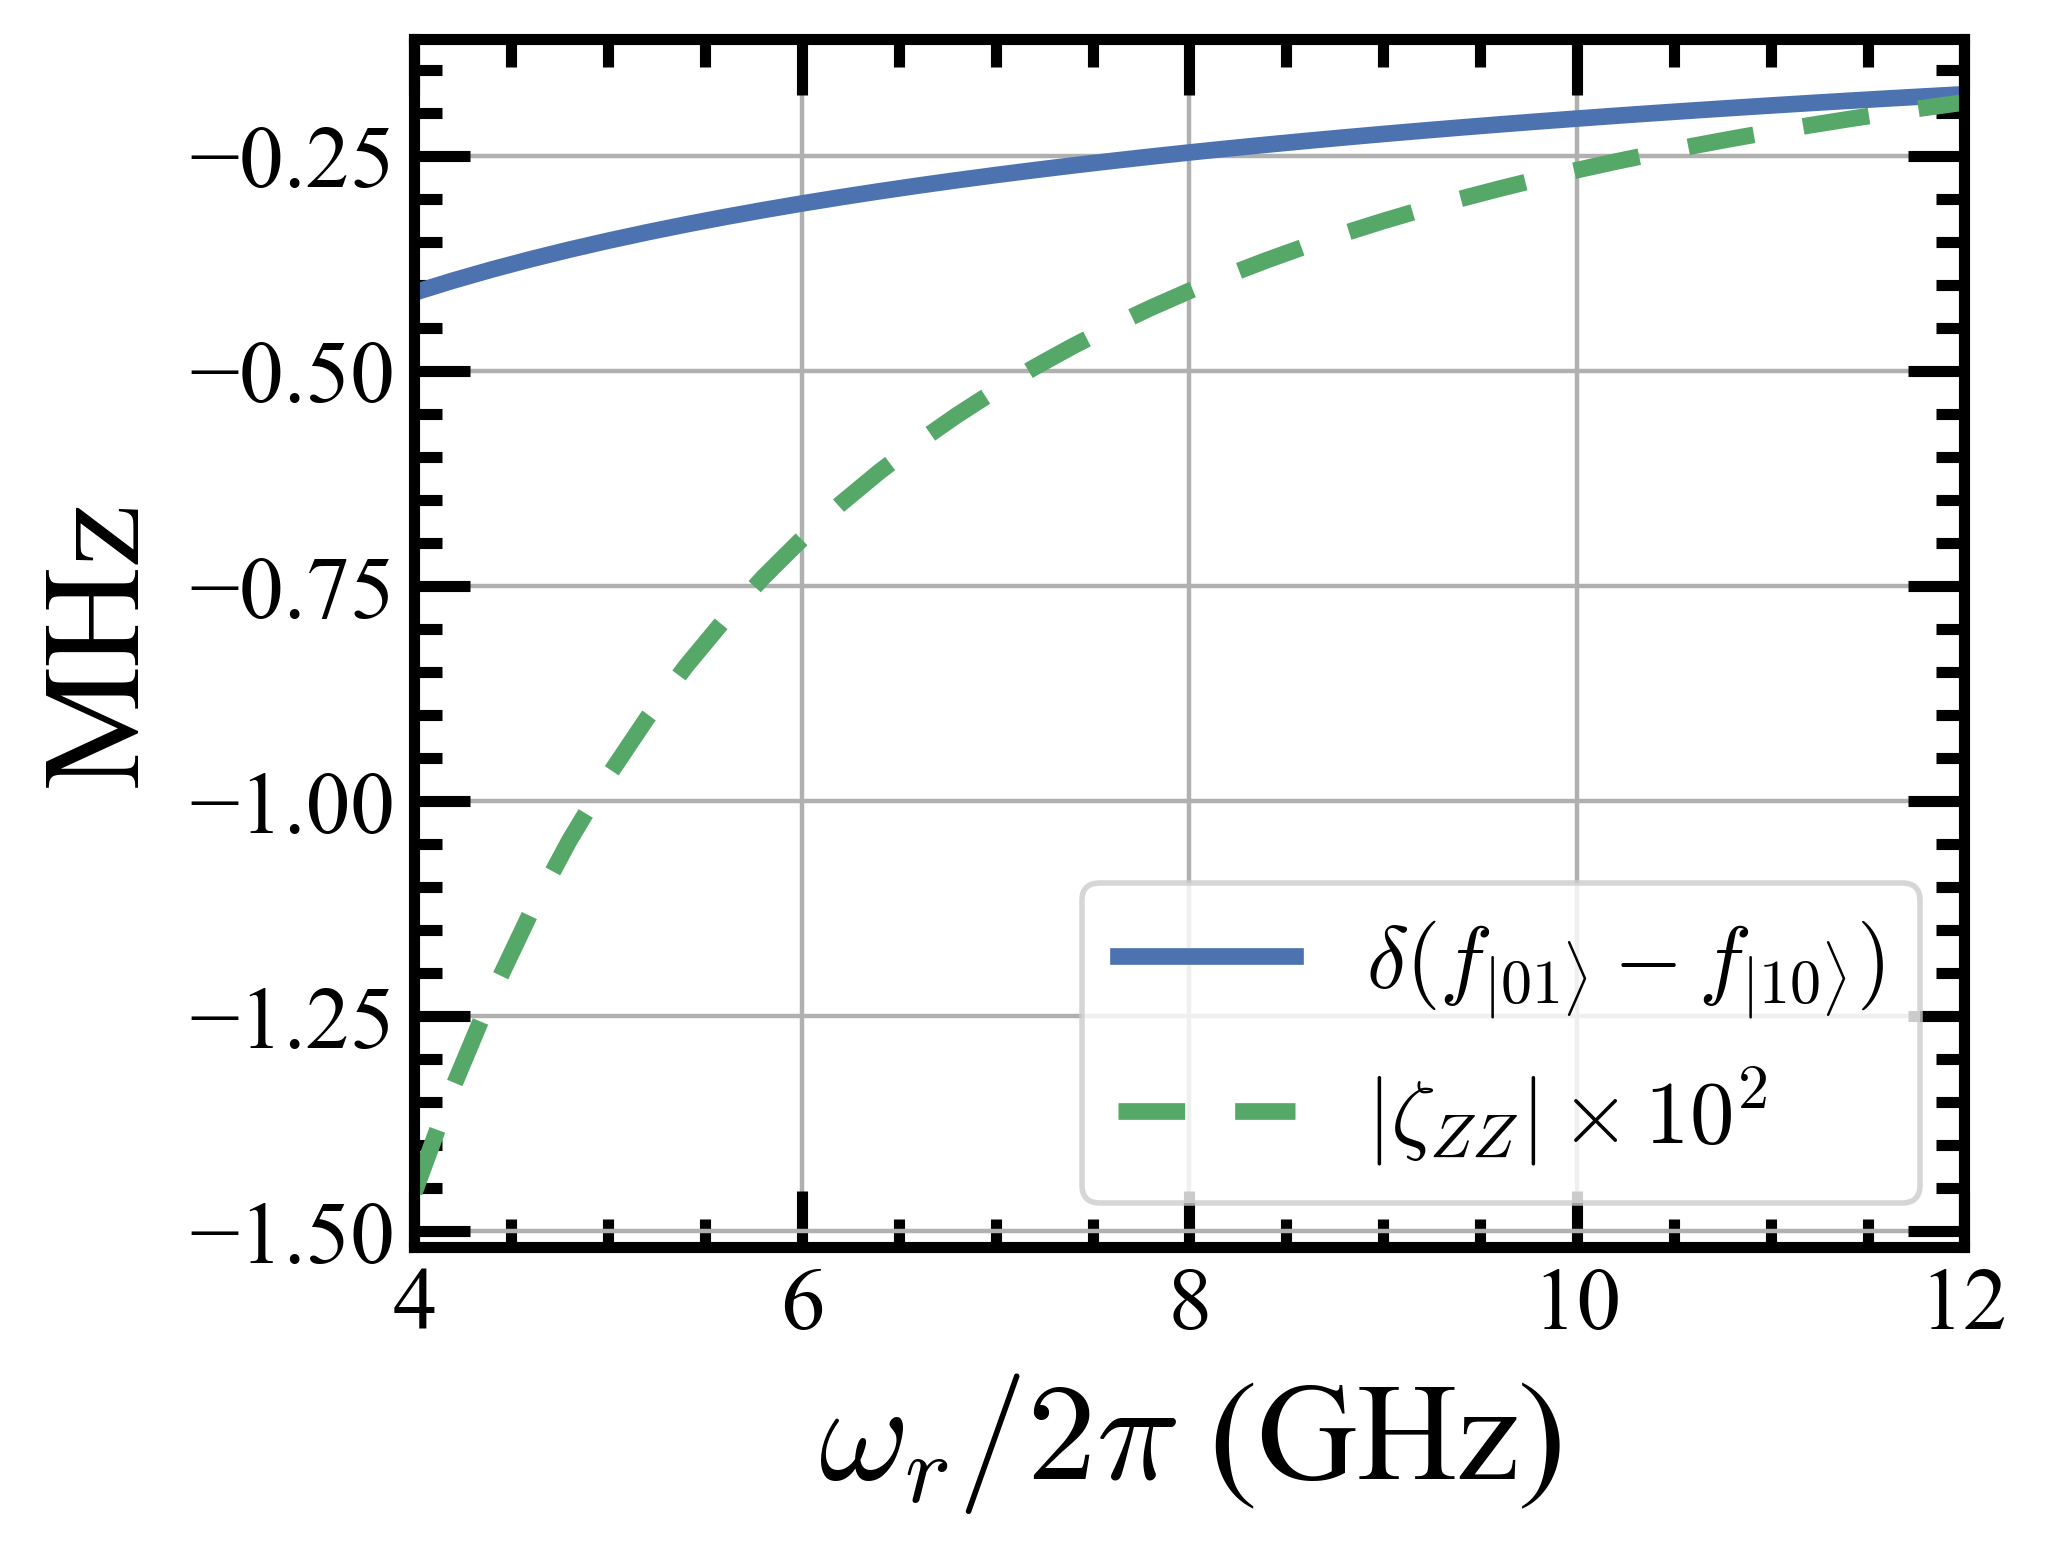

In [135]:
#Calculate ZZ rate:
plt.figure(figsize = [5,4])
zeta_ZZ = energies_coupled_swE[system.level_label('110'),:] - energies_coupled_swE[system.level_label('010'),:] \
- (energies_coupled_swE[system.level_label('100'), :] - energies_coupled_swE[system.level_label('000'), :])
freq_shift = energies_coupled_swE[system.level_label('010'), :] - energies_coupled_swE[system.level_label('100'), :]
freq_shift = freq_shift - freq_anchor
plt.plot(w_c_array, (freq_shift)*1e3, label = r'$\delta (f _{|01\rangle} - f _{|10\rangle})$')
plt.plot(w_c_array, (zeta_ZZ)*1e5, label = r'$|\zeta_{ZZ}|\times 10^2$',linestyle = '--')
plt.xlim([w_c_array[0], w_c_array[-1]])
plt.legend()
plt.grid()
plt.xlabel(r'$\omega_r/2\pi$ (GHz)')
plt.ylabel('MHz')
# figname = 'virtual_coupling_rate_2.pdf'
# plt.savefig(figpath+figname)

Text(0.5, 0, '$\\omega_r/2\\pi$ (GHz)')

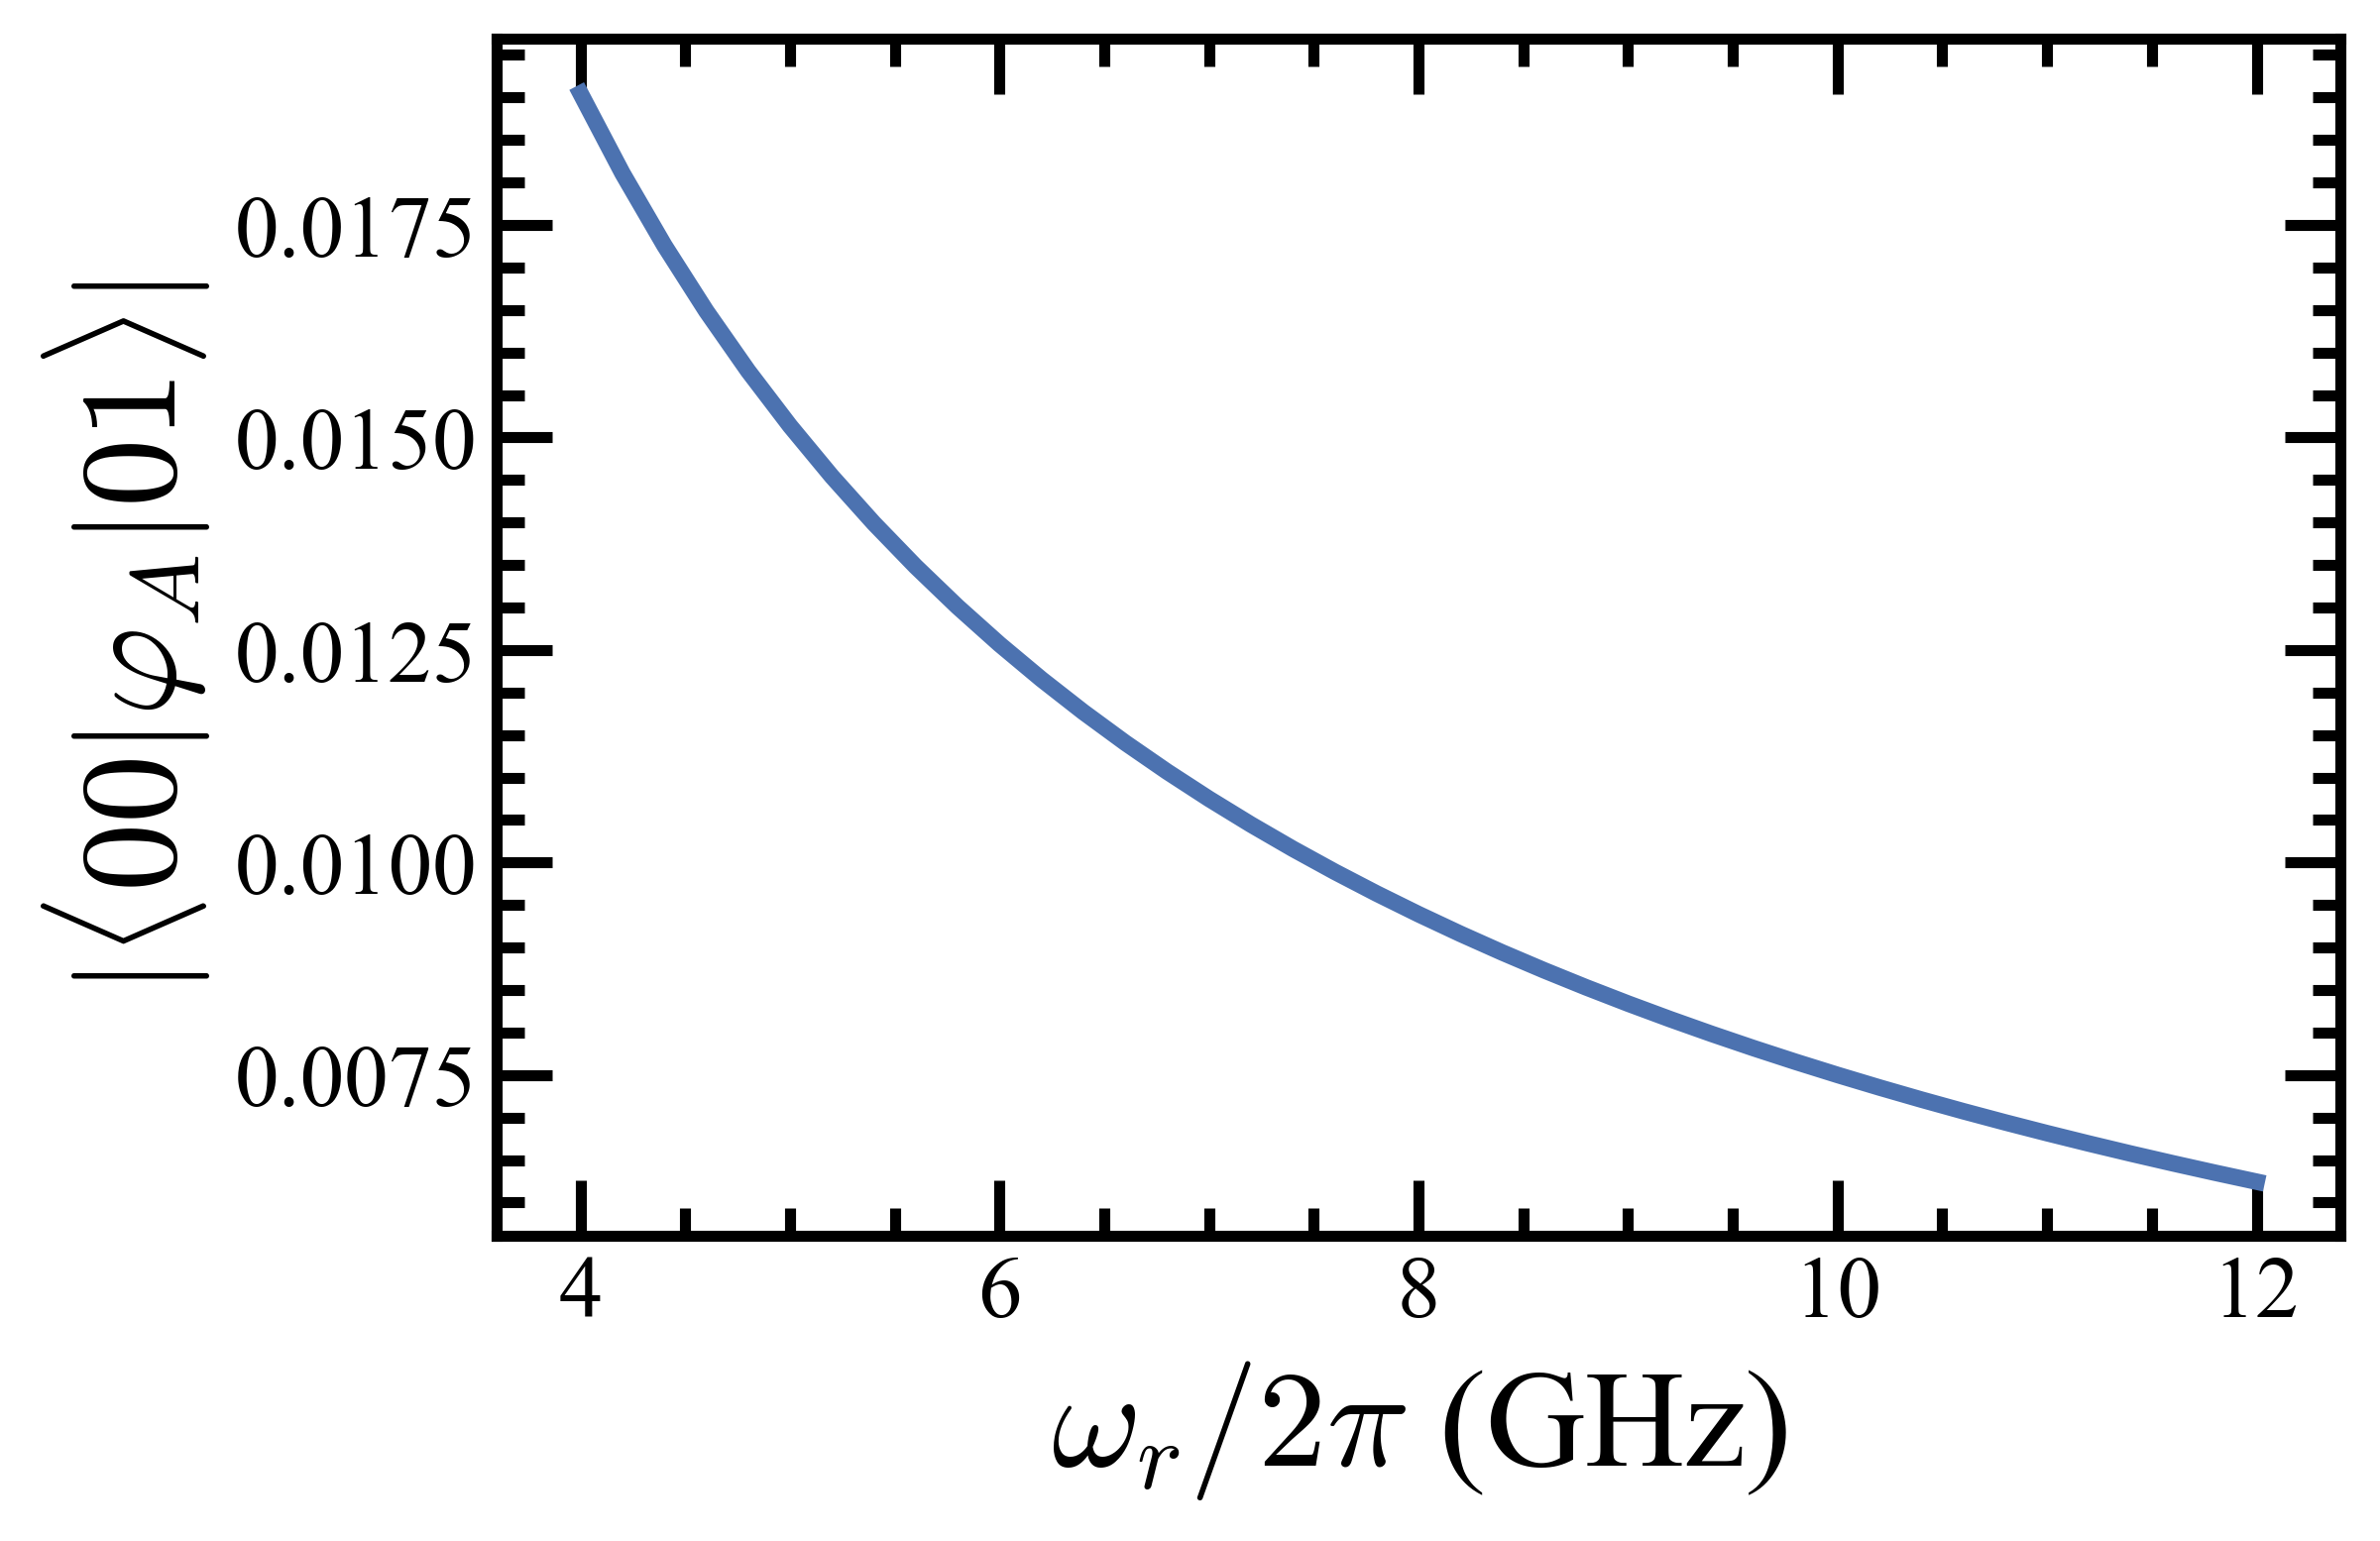

In [136]:
plt.plot(w_c_array, m_element_flux)
plt.ylabel(r'$|\langle 00 |\varphi_A |01 \rangle | $')
plt.xlabel(r'$\omega_r/2\pi$ (GHz)')

# plt.plot(w_c_array, m_element_charge)
# plt.ylabel(r'$|\langle 00 |n_A |01 \rangle | $')
# plt.xlabel(r'$\omega_r/2\pi$ (GHz)')

# Keep coupling to resonator fixed, sweep direct coupling

In [62]:
w_c = 7
J_C_array = np.linspace(0, 0.05, 51)
g = 0.2 #Coupling between qubits - resonator
m_element_charge = np.zeros_like(J_C_array)
m_element_flux = np.zeros_like(J_C_array)
phi_ext = np.pi
qubit1.phi_ext = phi_ext
qubit2.phi_ext = phi_ext
energies_coupled_swE = np.zeros((qubit1.nlev * qubit2.nlev*coupl_res.nlev, len(J_C_array)))
coupl_res = resonator.Cavity(omega=w_c, nlev = 5)
for idx, J_C in enumerate(J_C_array):
    system = coupobj.CoupledObjects(qubit1, qubit2, coupl_res,
                                    [qubit1, qubit2, J_C, 'charge'],
                                    [qubit1, coupl_res, g, 'JC-charge'],
                                    [qubit2, coupl_res, g, 'JC-charge'])
    energies_coupled_swE[:,idx] = system.levels()
    m_element_charge[idx] = abs(system.n(0).matrix_element(system.eigvec('000'), system.eigvec('010')))
    m_element_flux[idx] = abs(system.phi(0).matrix_element(system.eigvec('000'), system.eigvec('010')))

Text(0.5, 0, '$J_C$ (MHz)')

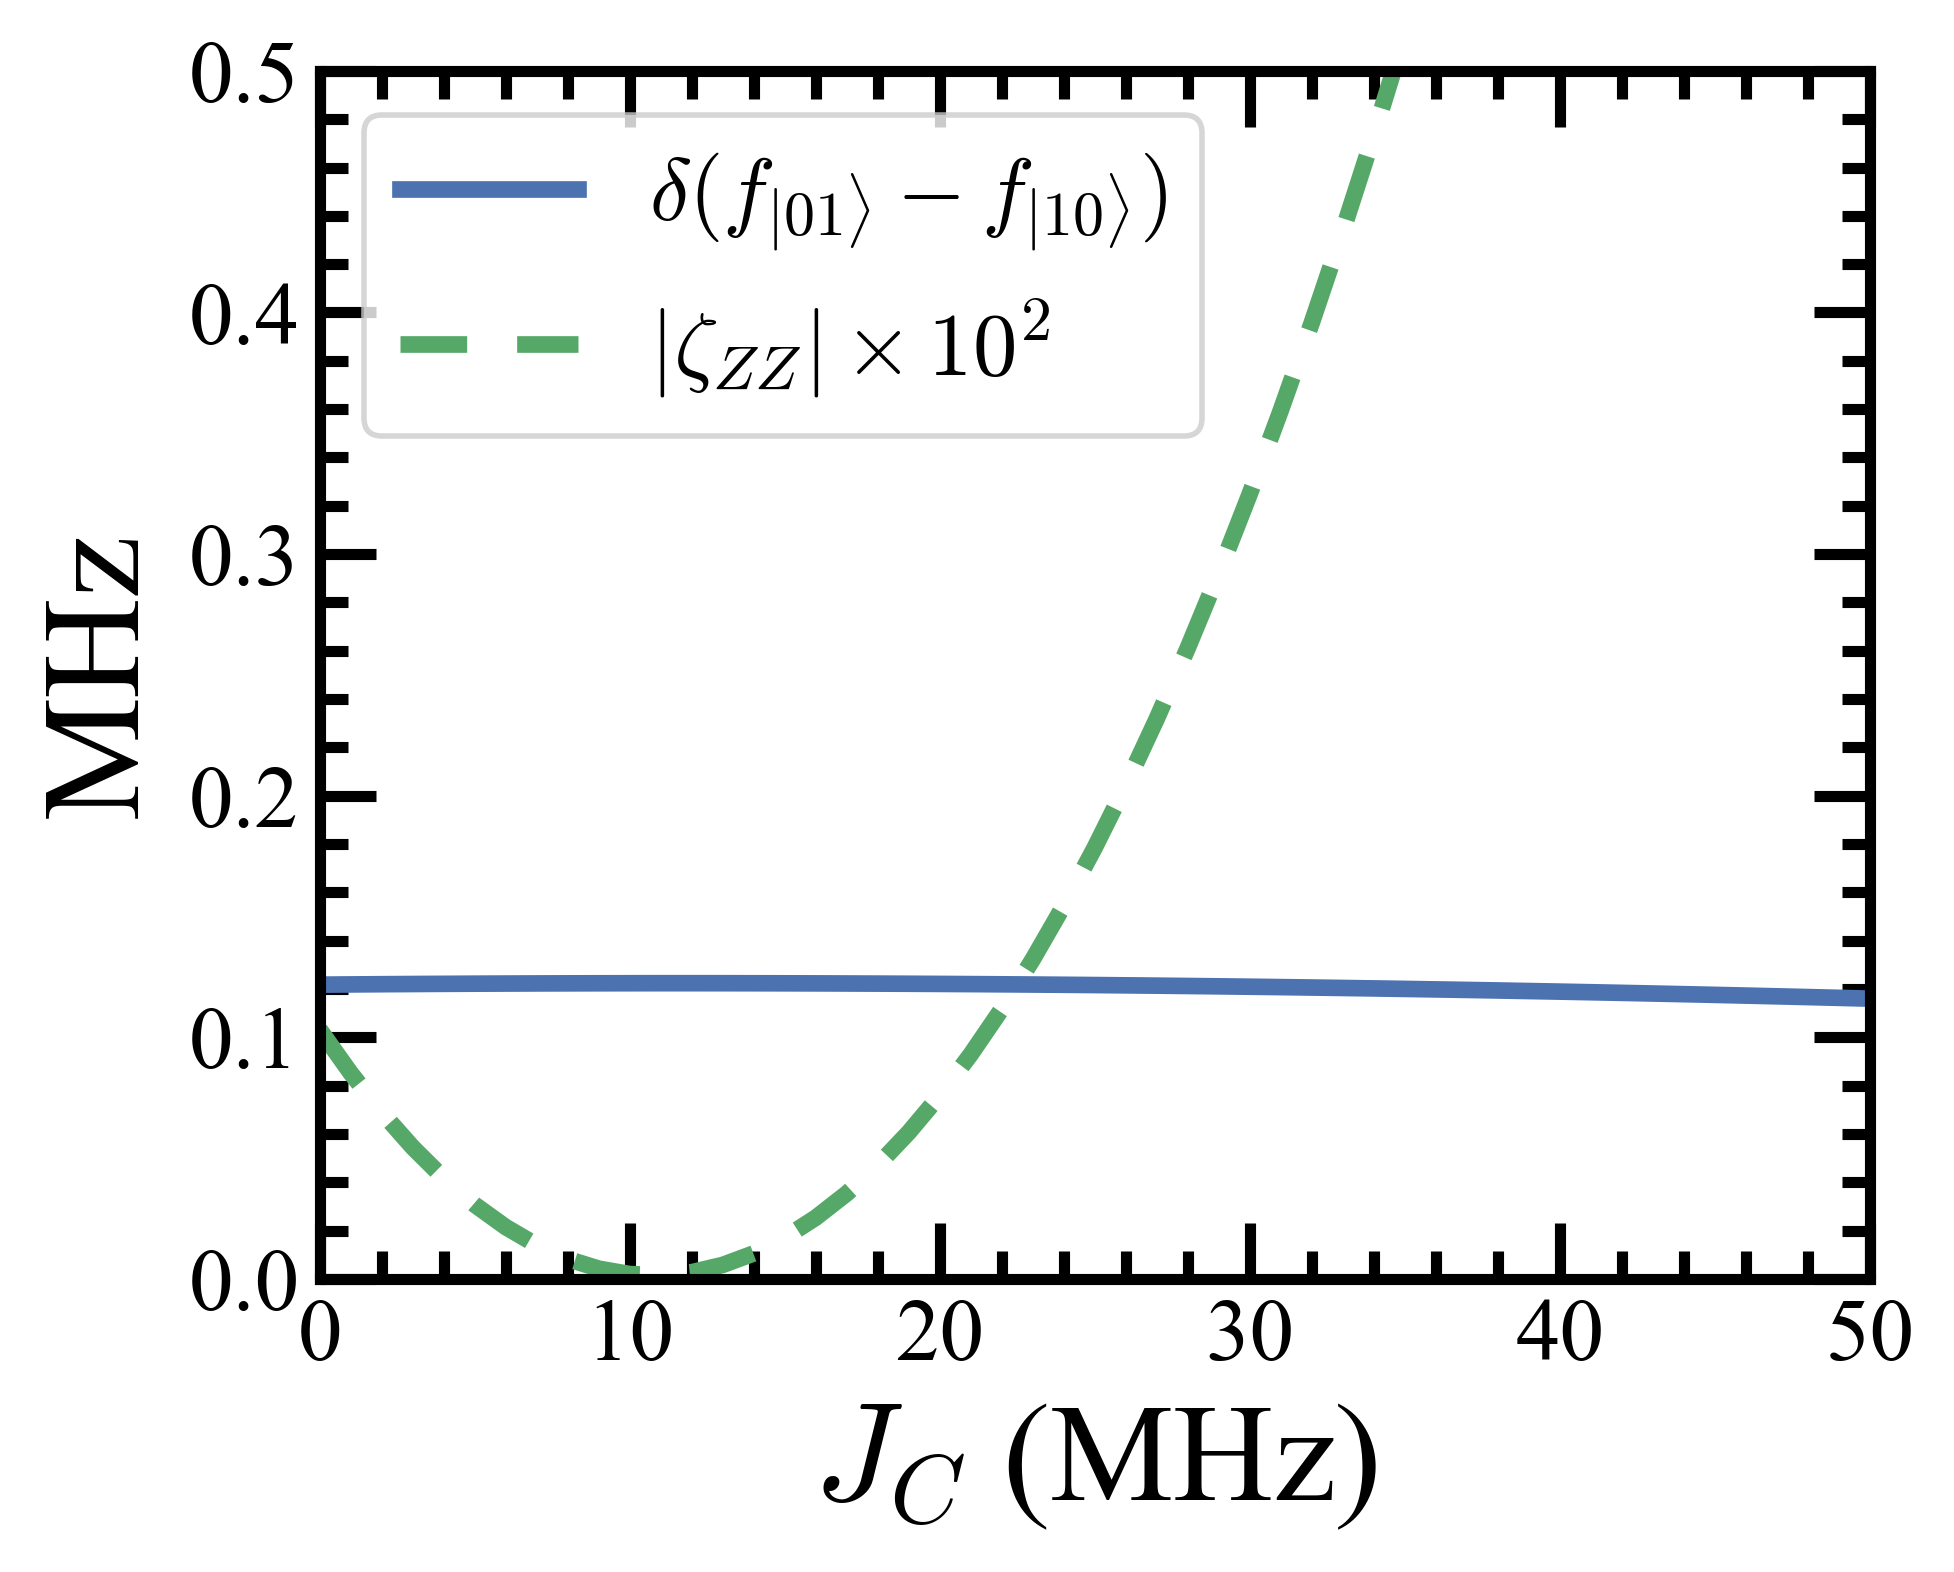

In [63]:
#Calculate ZZ rate:
plt.figure(figsize = [5,4])
zeta_ZZ = energies_coupled_swE[system.level_label('110'),:] - energies_coupled_swE[system.level_label('010'),:] \
- (energies_coupled_swE[system.level_label('100'), :] - energies_coupled_swE[system.level_label('000'), :])
freq_shift = energies_coupled_swE[system.level_label('010'), :] - energies_coupled_swE[system.level_label('100'), :]
freq_shift = freq_shift - freq_anchor
plt.plot(J_C_array*1e3, abs(freq_shift)*1e3, label = r'$\delta (f _{|01\rangle} - f _{|10\rangle})$')
plt.plot(J_C_array*1e3, abs(zeta_ZZ)*1e5, label = r'$|\zeta_{ZZ}|\times 10^2$',linestyle = '--')
plt.xlim([J_C_array[0]*1e3, J_C_array[-1]*1e3])
plt.ylim([0,0.5])
plt.legend()
plt.ylabel(r'MHz')
plt.xlabel('$J_C$ (MHz)')

Text(0.5, 0, '$J_C$ (MHz)')

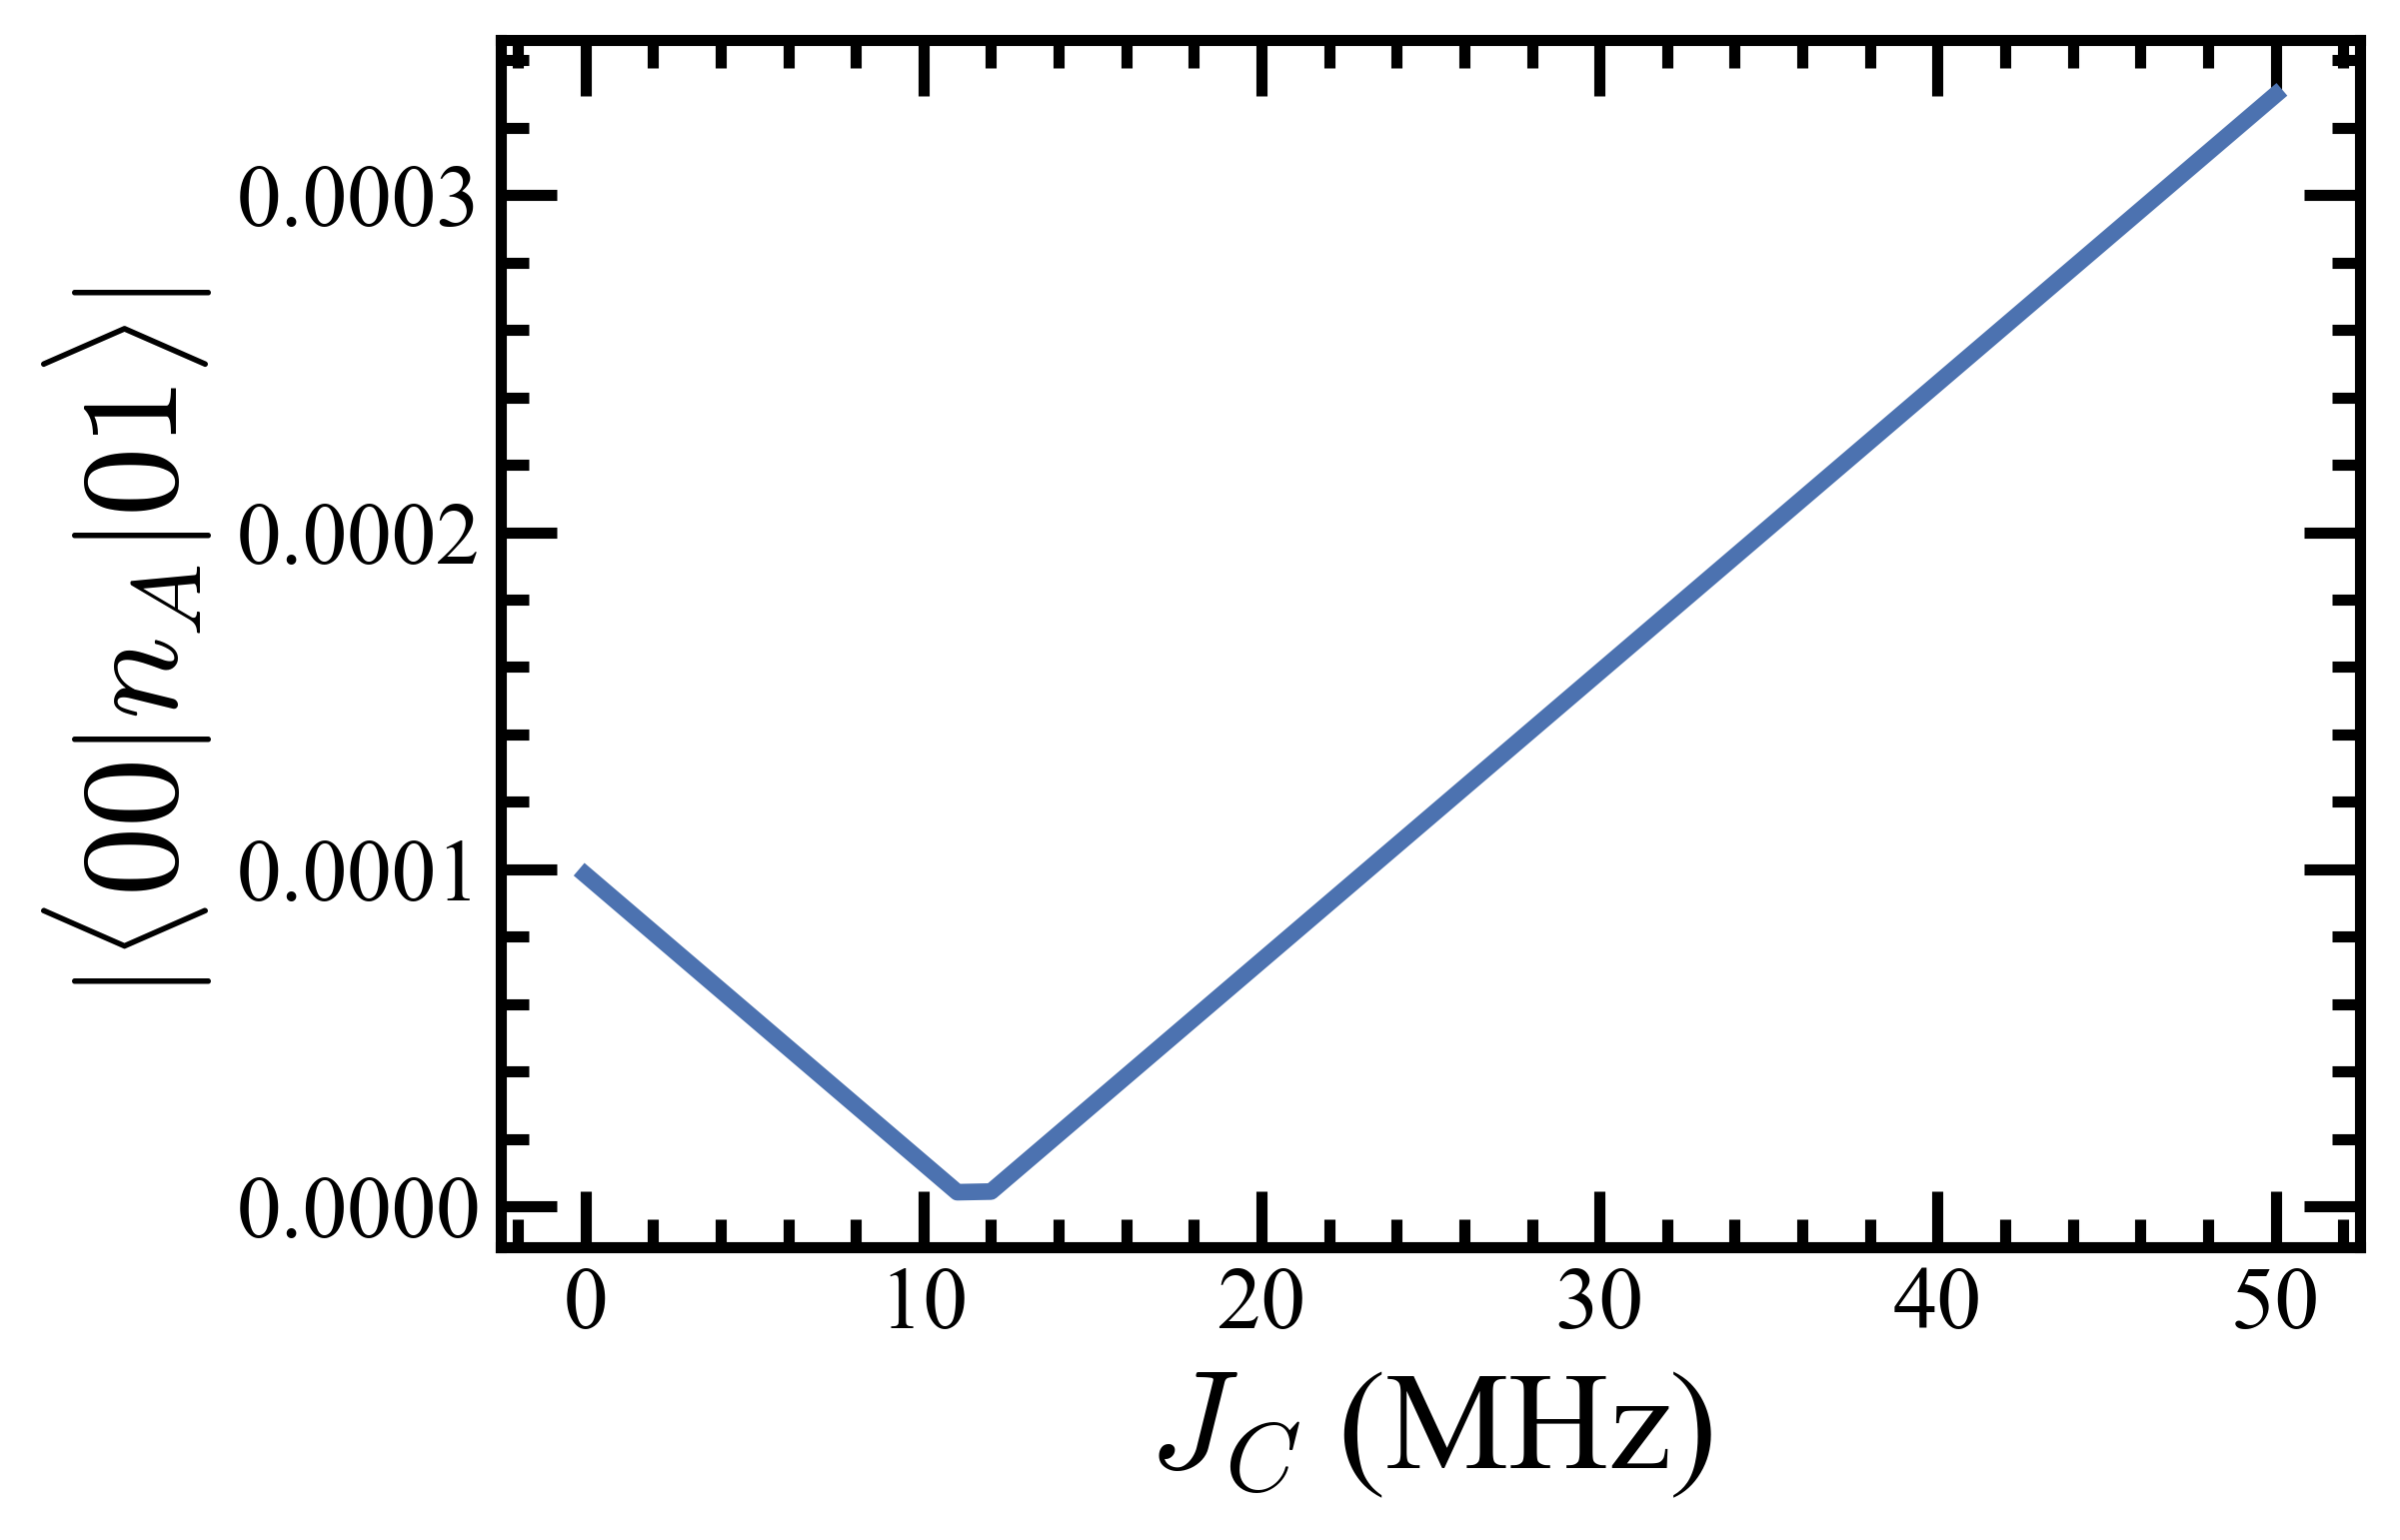

In [64]:
# plt.plot(J_C_array*1e3, m_element_flux)
# plt.ylabel(r'$|\langle 00 |\varphi_A |01 \rangle | $')
# plt.xlabel(r'$J_C$ (MHz)')

plt.plot(J_C_array*1e3, m_element_charge)
plt.ylabel(r'$|\langle 00 |n_A |01 \rangle | $')
plt.xlabel(r'$J_C$ (MHz)')

# Sweep qubit parameters

In [19]:
#Sweep EJ and EL
coupling_type = 'charge'
E_int_direct = 0.02
E_int_res = 0.3
qubit1.phi_ext = np.pi
qubit2.phi_ext = np.pi

EJ_array = np.linspace(2.5,4.5,201)
EL_array = np.linspace(0.4,1,201)
ZZ_rate_mult = np.zeros((len(EJ_array), len(EL_array)))

omega_c = 8
coupl_res = resonator.Cavity(omega=omega_c, nlev=5)

for EJ_idx, E_J2 in enumerate(EJ_array):
    for EL_idx, E_L2 in enumerate(EL_array): 
        qubit1 = fluxonium.Fluxonium(E_J = E_J1, E_C=E_C1, E_L=E_L1, phi_ext=phi_ext1, nlev = nlev_single, nlev_lc = nlev_lc)
        qubit2 = fluxonium.Fluxonium(E_J = E_J2, E_C=E_C2, E_L=E_L2, phi_ext=phi_ext2, nlev = nlev_single, nlev_lc = nlev_lc)
        system = coupobj.CoupledObjects(qubit1, qubit2, coupl_res,
                                    [qubit1, qubit2, E_int_direct, 'charge'],
                                    [coupl_res, qubit1, E_int_res, 'JC-charge'],
                                    [coupl_res, qubit2, E_int_res, 'JC-charge'])
        energies_coupled_mult = system.levels()
        ZZ_rate_mult[EJ_idx, EL_idx] = (energies_coupled_mult[system.level_label('110')] - energies_coupled_mult[system.level_label('010')]) \
        - (energies_coupled_mult[system.level_label('100')] - energies_coupled_mult[system.level_label('000')])

Text(0, 0.5, '$E_{L2}$ (GHz)')

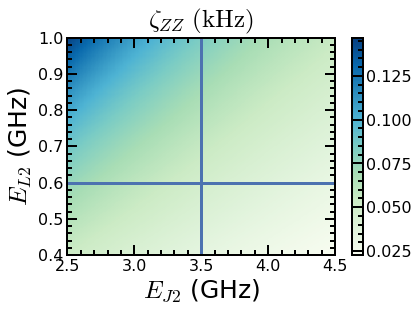

In [20]:
X,Y = np.meshgrid(EJ_array, EL_array)
Z = abs(ZZ_rate_mult).transpose()*1e6
plt.pcolor(X,Y,Z, cmap = 'GnBu')
plt.axvline(x=E_J1)
plt.axhline(y=E_L1)
plt.colorbar()
plt.title(r'$\zeta_{ZZ}~\mathrm{(kHz)}$')
plt.xlabel(r'$E_{J2}$ (GHz)')
plt.ylabel(r'$E_{L2}$ (GHz)')